In [1]:
import sys
sys.path.insert(0, "../../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util
import optax
from tqdm import tqdm

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils import data
from jax.tree_util import tree_map
import numpy as np

In [2]:
key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.array(pic)
  
mnist_dataset = datasets.MNIST('../../data', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=60000, num_workers=0)
dataset = next(iter(training_generator))[0]
data_std = jnp.max(jnp.std(dataset, axis = 0))
data_mean = jnp.mean(dataset, axis = 0)
dataset = (dataset - data_mean) / data_std

space_dim = (28, 28)

In [4]:
def get_samples(key, N = 1000):
    choice = jax.random.choice(key, jnp.arange(len(dataset)), (N,))
    return dataset[choice]

In [5]:
#
# Diffusion Parameters
#
alpha = 0.1
beta = 0.1

T = max(1/alpha, 1/beta)

print("final time = ", T)

final time =  10.0


In [6]:
N = 5
t = T

key, _ = jax.random.split(key)
x0 = get_samples(key, N)
key, _ = jax.random.split(key)
xi = jax.random.normal(key, (N,) + space_dim)
xt = x0 * jnp.exp(-alpha*t) + (1 - jnp.exp(-beta*t))*xi

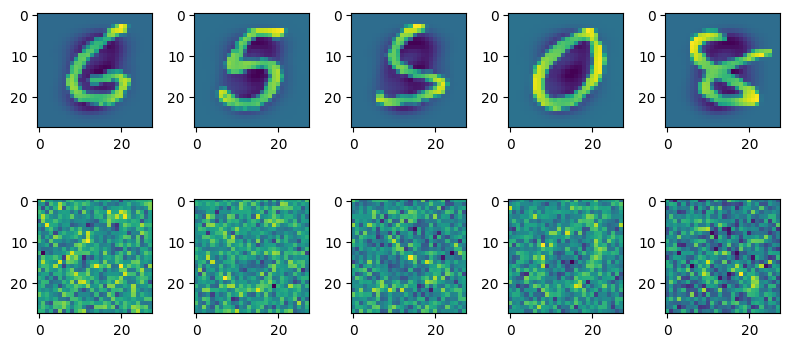

In [7]:
f, ax = plt.subplots(2, N, figsize = (8,4 ))
for i in range(N):
    ax[0, i].imshow(x0[i])
    ax[1, i].imshow(xt[i])

f.tight_layout()

In [66]:
act = lambda x: nn.softplus(x)

class ConvAutoencoder(nn.Module):
    latent_dim: int = 128  # Dimension of the latent space

    @nn.compact
    def __call__(self, x, time):

        # incorporate channel
        x = jnp.expand_dims(x, axis = -1)

        # Encoder
        x = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = act(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=16, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = act(x)
        x = nn.Conv(features=24, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = act(x)
        x = x.reshape((x.shape[0], 96))

        # time embedding
        y = nn.Dense(24)(time[:, None])
        y = act(y)
        y = nn.Dense(48)(y)
        y = act(y)
        y = nn.Dense(96)(y)

        # total
        z = x + y

        # Decoder
        z = nn.Dense(128)(z)
        z = z.reshape((z.shape[0], 1, 1, 128))
        z = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = act(z)
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = act(z)
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = act(z)
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = act(z)
        z = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = z[:, :28, :28, 0]
        return z

In [67]:
model = ConvAutoencoder()
param = model.init(key, jnp.empty((1,) + space_dim), jnp.empty((1,)))

In [68]:
@jax.jit
def calc_loss(param, samples, t, w):
    eval = model.apply(param, samples, t)
    a = jnp.sum(eval ** 2, axis = -1)
    c = 2*jnp.sum(w*jax.jvp(model.apply, (param, samples, t), (util.t_zeros_like(param), w, jnp.zeros_like(t)))[1], axis = -1)

    return jnp.mean(a + c)

@jax.jit
def grad_loss(param, samples, t, w):
    l = lambda param: calc_loss(param, samples, t, w)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [69]:
losses = []
param = model.init(key, jnp.empty((1,) + space_dim), jnp.empty((1,)))

In [70]:
optimiser = optax.adam(1e-3)
opt_state = optimiser.init(param)
N = 100

In [71]:
for i in tqdm(range(800)):
    key, _ = jax.random.split(key)
    x0 = get_samples(key, N)
    key, _ = jax.random.split(key)
    xi = jax.random.normal(key, (N,) + space_dim)
    key, _ = jax.random.split(key)
    t = jax.random.uniform(key, (N,)) * T
    xt = x0 * jnp.exp(-alpha*t[:, None, None]) + (1 - jnp.exp(-beta*t[:, None, None]))*xi
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N,) + space_dim)

    loss = calc_loss(param, xt, t, w)
    losses.append(loss)
    grad = grad_loss(param, xt, t, w)

    updates, opt_state = optimiser.update(grad, opt_state)
    param = optax.apply_updates(param, updates)

100%|██████████| 800/800 [05:12<00:00,  2.56it/s]


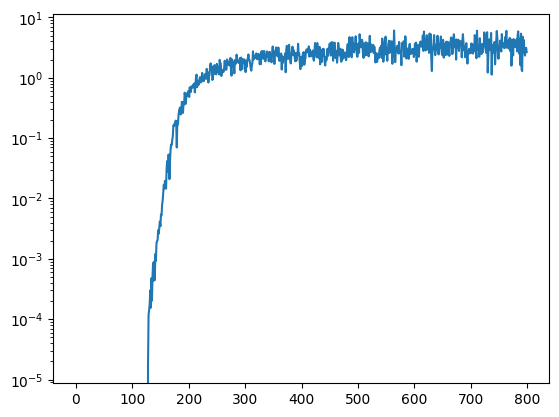

In [72]:
plt.plot(-jnp.array(losses))
# plt.ylim(-10, 10)
plt.yscale("log")

In [73]:
N = 5

x = jax.random.normal(key, (N,) + space_dim)

t = 0
epsilon = 0.5e-2
while t + epsilon < T:
    key, _ = jax.random.split(key)

    t_eval = T - t
    sig = (1 - jnp.exp(-beta * t_eval)) * jnp.sqrt(2*alpha + (2*beta*jnp.exp(-beta * t_eval))/(1 - jnp.exp(-beta*t_eval)))
    dx = (alpha * x + sig ** 2 * model.apply(param, x, jnp.ones((N,))*t_eval))*epsilon + sig * jnp.sqrt(epsilon) * jax.random.normal(key, (N,) + space_dim)
    x = x + dx
    t = t + epsilon

    print(t/T)

0.0005
0.001
0.0015
0.002
0.0025
0.003
0.0035000000000000005
0.004
0.0045
0.004999999999999999
0.0055
0.005999999999999999
0.006499999999999999
0.006999999999999999
0.0075
0.008
0.0085
0.009000000000000001
0.009500000000000001
0.010000000000000002
0.010500000000000002
0.011000000000000003
0.011500000000000003
0.012000000000000004
0.012500000000000002
0.013000000000000003
0.013500000000000003
0.014000000000000004
0.014500000000000004
0.015000000000000005
0.015500000000000005
0.016000000000000007
0.016500000000000008
0.017000000000000008
0.01750000000000001
0.01800000000000001
0.01850000000000001
0.01900000000000001
0.01950000000000001
0.02000000000000001
0.02050000000000001
0.02100000000000001
0.021500000000000012
0.022000000000000013
0.022500000000000013
0.023000000000000013
0.023500000000000014
0.024000000000000014
0.024500000000000015
0.025000000000000012
0.025500000000000012
0.026000000000000013
0.026500000000000013
0.027000000000000014
0.027500000000000014
0.028000000000000014
0.02

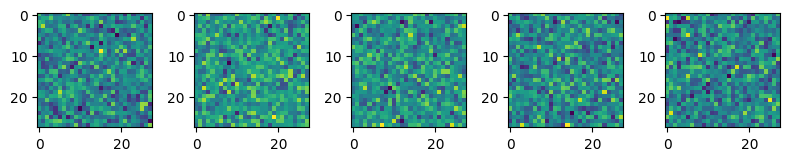

In [74]:
f, ax = plt.subplots(1, N, figsize = (8,4 ))
for i in range(N):
    ax[i].imshow(x[i])

f.tight_layout()

---